## Import the required packages

In [ ]:
from time import time
import scipy.io

import matplotlib.pyplot as plt
import numpy as np
import random

# Setup the seeds for numpy and random to reproduce the results
np.random.seed(0)
random.seed(0)


## Load the data

In [ ]:
# Setup the matplotlib plot params
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

#Load data
mat_contents = scipy.io.loadmat('../data/faceImages.mat')
# Face images of 37 people in various lighting conditions
# of width 168 and height 192, flattened in 32256 vectors
# each person has about 59-64 images of their faces resulting
# in 2410 images in total


faces = mat_contents['faces'] # Raw data with features as rows and samples in columns
m = int(mat_contents['m'][0,0]) #image-width
n = int(mat_contents['n'][0,0]) #image-height

X = faces.T # Data usual format of sample rows and feature columns
nfaces = np.ndarray.flatten(mat_contents['nfaces']).astype(np.int32) #count of images per person

# creating labels
y = np.zeros((faces.shape[1], 1),dtype=np.int32)
j = 0
classes = list(range(len(nfaces)))
for i in nfaces:
  y[j:j+i] = classes.pop(0)
  j = j + i

## Dataset sizes

In [ ]:
print(f"m (image-height):{m}, n(image-width):{n}")
print(f"input data shape:{X.shape}")
print(f"input labels shape:{y.shape}")
print(f"no. of classes:{np.max(y)}")
print(f"samples per class:{nfaces}")

## Split into a training and testing set

### Task 01
Split in to training and testing data with 60-40 split. i.e 60% for training and 40% for testing using `train_test_split` from sklearn module, also set `shuffle=True`.

In [ ]:
from sklearn.model_selection import train_test_split
X_tv, X_test, y_tv, y_test = train_test_split(....)

## Dimensionality reduction using PCA

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA


n_components = 150 #Reduced dimensional size

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_tv.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_tv)
print("done in %0.3fs" % (time() - t0))

t0 = time()
X_tv_pca = pca.transform(X_tv)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

## Check the dimension of the PCA transformation

In [ ]:
print(f"PCA components shape: {pca.components_.shape}") #Shape of the PCA components
print(f"PCA transfomed training data shape: {X_tv_pca.shape}") # Shape of the dimension reduced training data
print(f"PCA transfomed testing data shape: {X_test_pca.shape}") # Shape of the dimension reduced testing data

### Plot PCA eigenfaces

Visualizing the 5 PCA components as images. These are the eigen vectors obtained from PCA, but of face images and are referred to as `eigenfaces`.

In [ ]:
eigenfaces = pca.components_.reshape((n_components, m, n))
print("Projecting the input data on the eigenfaces orthonormal basis")

# Plot first 5 eigenfaces
fig1 = plt.figure(figsize=(10, 3))

for i in range(5):
  ax = fig1.add_subplot(1, 5, i+1)
  img = ax.imshow(eigenfaces[i].T)
  img.set_cmap('gray')
  ax.set_title(f"Eigenface {i+1}")
  plt.axis('off')

plt.tight_layout()
plt.show()

## Facial Recognition with k-NN classifer

### Train a k-NN classifier
k-NN classifier is set with 5 nearest neighbors. Train the classifer using the `fit` method with `X_tv_pca, y_tv.ravel()` as inputs.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

print("Fitting the classifier to the training set")
t0 = time()
clf = KNeighborsClassifier(n_neighbors=5)

#call fit here

print("done in %0.3fs" % (time() - t0))

### Quantitative evaluation of the model quality on the test set
We will be using the `classification_report` and `confusion_matrix` functions. `confusion_matrix` shows you a summary of how each instance class is classified as, thus reporting any 'confusion' on behalf of the trained classifier.

### Task 02
`classification_report` reports the `precision`, `recall`, `f1-score` of the classifer. Read up on these terms and report their definitions here.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

target_names = [f"Person{n}" for n in range(1,39)]
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print(cm)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [10, 10]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

disp.plot()

### Qualitative evaluation of the predictions using matplotlib
The following code will help you see the classification results of the images as a gallery.

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[int(y_pred[i])]
    true_name = target_names[int(y_test[i])]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4, rgb=False):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if rgb == False:
          plt.tight_layout()
          plt.imshow(images[i].reshape((h, w)).T, cmap=plt.cm.gray)
        else:
          plt.tight_layout()
          plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.axis('off')


In [ ]:
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, m, n)

### Setup for task 03
In the row 34 of the `ConfusionMatrixDisplay` image the `class label 34` is confused with `class label 1` in 11 instances. Rerun the whole ipynb with `stratify=y` parameter passed to `train_test_split`. Remember to clear all outputs of the cells, restart the kernal and then run all the cells of the ipynb. This helps in clearing out any cached results in the cells. 

In vscode you will see them in the following tabs/pane. 

![Screenshot from 2025-09-12 06-35.png](<attachment:Screenshot from 2025-09-12 06-35.png>)

In jupyter-lab / jupyter-notebook you will see them in the following tabs/pane.

![Screenshot from 2025-09-12 06-34-22.png](<attachment:Screenshot from 2025-09-12 06-34-22.png>)

![Screenshot from 2025-09-12 06-34-31.png](<attachment:Screenshot from 2025-09-12 06-34-31.png>)

If your are running the ipynb from the terminal these actions are not required as terminal clears the cache on each run.
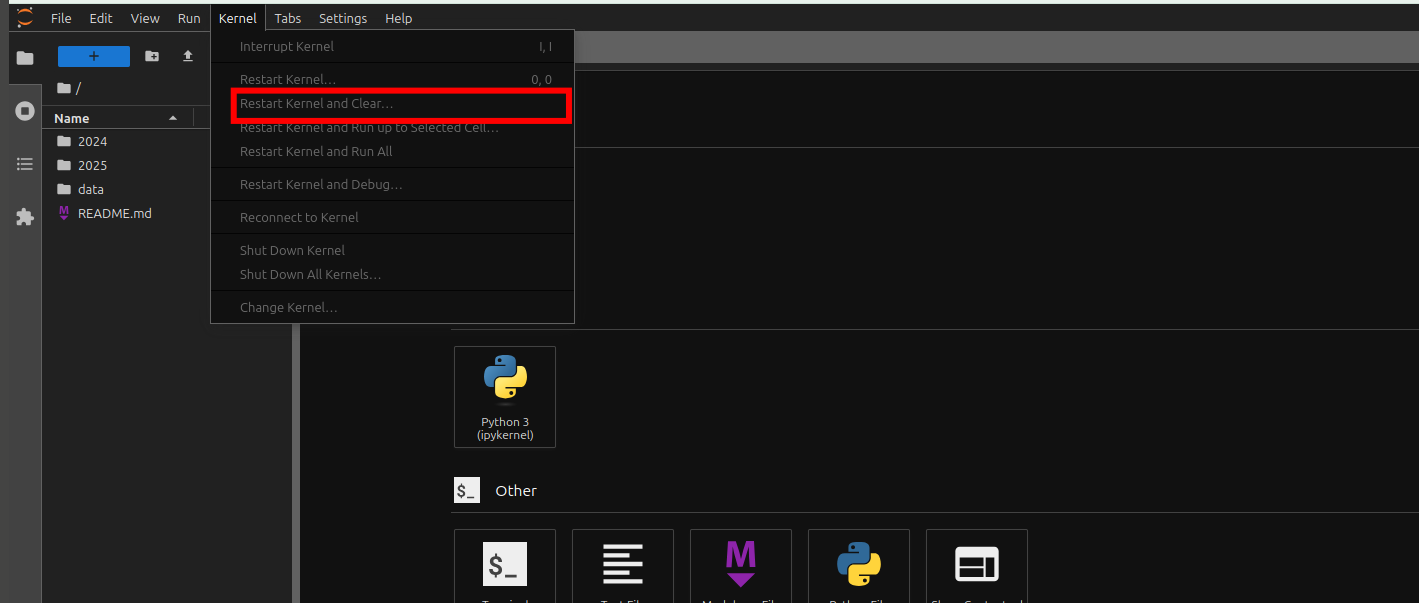
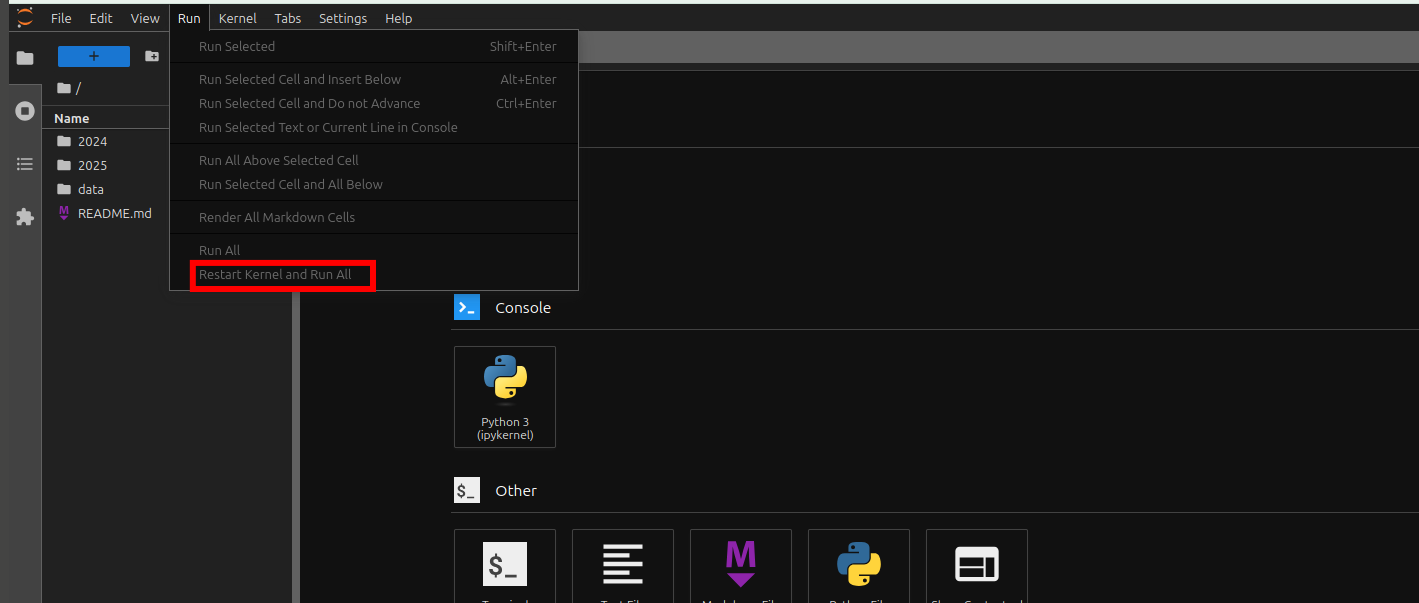
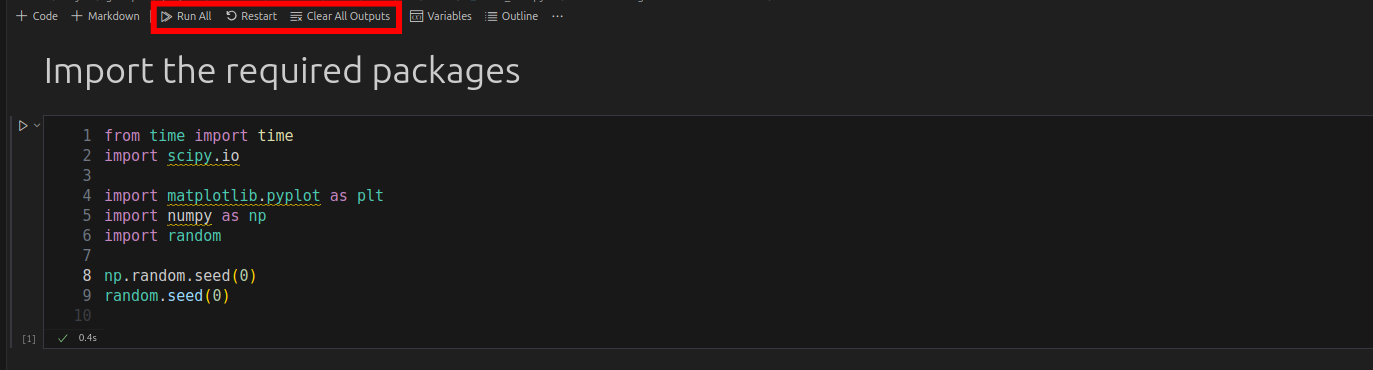

### Task 03

Did the results improve or get worse?

Read up on stratification of train-test split. Explaing what it does.

Reason how stratification split is changing the classifier performance.